# Import Libraries

In [6]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import Datasets

In [7]:
games = pd.read_csv('data/games.csv')
details = pd.read_csv('data/games_details.csv')
teams = pd.read_csv('data/teams.csv')
players = pd.read_csv('data/players.csv')
ranking = pd.read_csv('data/ranking.csv')

C:\Users\tojoy\AppData\Local\Temp\ipykernel_8556\1677706802.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv('data/games_details.csv')


In [8]:
ranking.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


# Data Preparation

## Get Labels
Here we drop the rows when a team didn't play enough games in one season (not 82 games).

In [9]:
def get_labels(ranking):
    temp = ranking.copy(deep=False)
    temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()
    temp = pd.DataFrame(temp)
    temp.reset_index(inplace=True)
    drops = []
    for i in range(len(temp)):
        if temp.iloc[i,1] / 10000 > 2:
            temp.iloc[i,1] = temp.iloc[i,1] % 10000
        else:
            drops.append(i)
            continue
        if (temp.iloc[i,2] != 82):
            drops.append(i)
    for i in range(len(drops)):
        temp.drop([drops[i]], inplace=True)
    temp.reset_index(inplace=True)
    temp.drop(columns=['index'], inplace=True)
    temp.drop(columns=['G'], inplace=True)
#     temp = pd.merge(temp, ranking, how='left', left_on=['TEAM_ID','STANDINGSDATE'], right_on = ['TEAM_ID','STANDINGSDATE'])
#     temp.drop(columns=['STANDINGSDATE','LEAGUE_ID','SEASON_ID_y','CONFERENCE','TEAM','G','W','L','HOME_RECORD','ROAD_RECORD','RETURNTOPLAY'], inplace=True)
    return temp

In [10]:
labels = get_labels(ranking)
labels

C:\Users\tojoy\AppData\Local\Temp\ipykernel_8556\667405560.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()


,TEAM_ID,SEASON_ID,W
0,1610612737,2002,35
1,1610612737,2003,28
2,1610612737,2004,13
3,1610612737,2005,26
4,1610612737,2006,30
...,...,...,...
501,1610612766,2015,48
502,1610612766,2016,36
503,1610612766,2017,36
504,1610612766,2018,39


In [11]:
len(labels['TEAM_ID'].unique())

30

## Get Features

In [12]:
def get_features(games, details):
    temp = pd.merge(games, details, how='left', left_on=['GAME_ID'], right_on = ['GAME_ID'])
    temp = temp[['TEAM_ID','SEASON','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']]
    temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS'].sum()
    temp = pd.DataFrame(temp)
    next_season = []
    temp.reset_index(inplace=True)
    for i in range(len(temp)):
        next_season.append(temp.iloc[i,1] + 1)
    temp['NEXT_SEASON'] = next_season
    return temp

In [13]:
features = get_features(games, details)
features

C:\Users\tojoy\AppData\Local\Temp\ipykernel_8556\2543770804.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'


,TEAM_ID,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_SEASON
0,1.610613e+09,2003,2857.0,6609.0,320.764,422.0,1256.0,104.083,1555.0,2004.0,...,2543.0,3548.0,1666.0,633.0,410.0,1292.0,1853.0,7691.0,-1905.0,2004
1,1.610613e+09,2004,2997.0,6821.0,357.705,309.0,997.0,114.160,1456.0,2059.0,...,2387.0,3510.0,1649.0,642.0,350.0,1289.0,2068.0,7759.0,-3983.0,2005
2,1.610613e+09,2005,3196.0,6997.0,358.522,450.0,1205.0,138.741,1804.0,2404.0,...,2427.0,3568.0,1759.0,633.0,417.0,1377.0,2235.0,8646.0,-1950.0,2006
3,1.610613e+09,2006,3105.0,6986.0,369.110,385.0,1161.0,127.166,1865.0,2438.0,...,2528.0,3595.0,1728.0,663.0,480.0,1400.0,2195.0,8460.0,-1950.0,2007
4,1.610613e+09,2007,3457.0,7668.0,382.692,436.0,1250.0,122.879,2129.0,2758.0,...,2885.0,4074.0,2084.0,696.0,536.0,1411.0,2016.0,9479.0,-1165.0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1.610613e+09,2018,3495.0,7788.0,413.804,1043.0,2949.0,245.989,1619.0,2046.0,...,2980.0,3824.0,2029.0,625.0,435.0,1038.0,1679.0,9652.0,-330.0,2019
595,1.610613e+09,2019,2615.0,6015.0,297.664,839.0,2397.0,180.742,1135.0,1506.0,...,2249.0,3012.0,1668.0,466.0,297.0,1008.0,1333.0,7204.0,-2260.0,2020
596,1.610613e+09,2020,3210.0,7117.0,352.732,1095.0,2976.0,211.146,1299.0,1729.0,...,2704.0,3559.0,2173.0,640.0,386.0,1160.0,1485.0,8814.0,-899.0,2021
597,1.610613e+09,2021,3685.0,7945.0,398.470,1190.0,3301.0,218.024,1373.0,1859.0,...,2934.0,3877.0,2409.0,747.0,428.0,1129.0,1736.0,9933.0,-380.0,2022


## Get Full Dataset
Here we drop NaN values. We then do inner join of the two tables, so some values are also dropped because some values don't exist in both tables.

In [14]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [15]:
def get_data(ranking, games, details):
    labels = get_labels(ranking)
    features = get_features(games, details)
    data = pd.merge(labels, features, how='left', left_on=['TEAM_ID','SEASON_ID'], right_on = ['TEAM_ID','NEXT_SEASON'])
    data.drop(columns=['SEASON_ID','SEASON'], inplace=True)
    data.dropna(inplace=True)
    data = swap_columns(data, 'W', 'NEXT_SEASON')
    data = data.astype({'NEXT_SEASON': 'int64'})
    data.rename(columns={'W' : 'NEXT_W'}, inplace=True)
    data.reset_index(inplace=True)
    data.drop(columns=['index'], inplace=True)
    return data

In [16]:
data = get_data(ranking, games, details)
data

C:\Users\tojoy\AppData\Local\Temp\ipykernel_8556\667405560.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()
C:\Users\tojoy\AppData\Local\Temp\ipykernel_8556\2543770804.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'


,TEAM_ID,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_W
0,1610612737,2004,2857.0,6609.0,320.764,422.0,1256.0,104.083,1555.0,2004.0,...,2543.0,3548.0,1666.0,633.0,410.0,1292.0,1853.0,7691.0,-1905.0,13
1,1610612737,2005,2997.0,6821.0,357.705,309.0,997.0,114.160,1456.0,2059.0,...,2387.0,3510.0,1649.0,642.0,350.0,1289.0,2068.0,7759.0,-3983.0,26
2,1610612737,2006,3196.0,6997.0,358.522,450.0,1205.0,138.741,1804.0,2404.0,...,2427.0,3568.0,1759.0,633.0,417.0,1377.0,2235.0,8646.0,-1950.0,30
3,1610612737,2007,3105.0,6986.0,369.110,385.0,1161.0,127.166,1865.0,2438.0,...,2528.0,3595.0,1728.0,663.0,480.0,1400.0,2195.0,8460.0,-1950.0,37
4,1610612737,2008,3457.0,7668.0,382.692,436.0,1250.0,122.879,2129.0,2758.0,...,2885.0,4074.0,2084.0,696.0,536.0,1411.0,2016.0,9479.0,-1165.0,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,1610612766,2015,3191.0,7612.0,370.551,551.0,1736.0,154.944,1547.0,2057.0,...,3070.0,3965.0,1833.0,552.0,492.0,1017.0,1691.0,8480.0,-1430.0,48
443,1610612766,2016,3528.0,8122.0,425.323,987.0,2745.0,266.812,1859.0,2352.0,...,3403.0,4246.0,2027.0,691.0,485.0,1140.0,1758.0,9902.0,1195.0,36
444,1610612766,2017,3318.0,7589.0,387.285,866.0,2526.0,188.367,1741.0,2146.0,...,3111.0,3904.0,2024.0,621.0,425.0,1004.0,1486.0,9243.0,-175.0,36
445,1610612766,2018,3386.0,7537.0,390.534,872.0,2379.0,212.096,1738.0,2334.0,...,3078.0,3954.0,1869.0,594.0,393.0,1093.0,1502.0,9382.0,90.0,39


In [17]:
data.to_csv('data/nba_data.csv')

## Feature Scaling
We use z-score normalization.

In [18]:
def scale_data(data):
    temp = data.copy(deep=False)
    std_slc = StandardScaler()
    preprocess = std_slc.fit_transform(temp[['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']])
#     preprocess = preprocessing.normalize(temp[['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
#              ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']])
    data_scaled = pd.DataFrame(preprocess, columns=['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM'
                    ,'FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS'])
    data_scaled.insert(0,'TEAM_ID',temp[['TEAM_ID']])
    data_scaled.insert(1,'NEXT_SEASON',temp[['NEXT_SEASON']])
    data_scaled.insert(21,'NEXT_W',temp[['NEXT_W']])
    return data_scaled

In [19]:
data_scaled = scale_data(data)
data_scaled

,TEAM_ID,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_W
0,1610612737,2004,-1.411461,-1.264087,-1.498915,-1.106395,-1.073258,-1.705786,-0.471266,-0.614104,...,-0.976307,-0.816891,-1.158351,-0.629734,-0.391299,0.083757,-0.344346,-1.358318,-0.988451,13
1,1610612737,2005,-1.059369,-0.977735,-0.786667,-1.577773,-1.486932,-1.490412,-0.839727,-0.461249,...,-1.413032,-0.907023,-1.218349,-0.541993,-1.073390,0.063306,0.511068,-1.297323,-2.069663,26
2,1610612737,2006,-0.558896,-0.740009,-0.770914,-0.989593,-1.154715,-0.965047,0.455471,0.497565,...,-1.301051,-0.769454,-0.830124,-0.629734,-0.311722,0.663208,1.175506,-0.501689,-1.011865,30
3,1610612737,2007,-0.787756,-0.754867,-0.566770,-1.260740,-1.224992,-1.212437,0.682503,0.592057,...,-1.018299,-0.705412,-0.939533,-0.337266,0.404473,0.820000,1.016359,-0.668530,-1.011865,37
4,1610612737,2008,0.097503,0.166323,-0.304900,-1.047994,-1.082842,-1.304063,1.665067,1.481392,...,-0.018870,0.430724,0.316904,-0.015550,1.041091,0.894988,0.304177,0.245508,-0.603419,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,1610612766,2015,-0.571471,0.090682,-0.538987,-0.568274,-0.306604,-0.618743,-0.501040,-0.466808,...,0.499041,0.172188,-0.568954,-1.419399,0.540891,-1.790936,-0.988891,-0.650590,-0.741302,48
443,1610612766,2016,0.276064,0.779548,0.517056,1.250493,1.304966,1.772191,0.660172,0.353048,...,1.431282,0.838690,0.115733,-0.064295,0.461314,-0.952437,-0.722320,0.624936,0.624522,36
444,1610612766,2017,-0.252074,0.059616,-0.216343,0.745744,0.955180,0.095600,0.220995,-0.219461,...,0.613822,0.027502,0.105145,-0.746721,-0.220777,-1.879558,-1.804519,0.033817,-0.088308,36
445,1610612766,2018,-0.081058,-0.010621,-0.153700,0.770773,0.720392,0.602756,0.209830,0.303023,...,0.521438,0.146097,-0.441899,-1.009943,-0.584558,-1.272839,-1.740860,0.158499,0.049575,39


In [20]:
data_scaled.describe()

,TEAM_ID,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_W
count,4.470000e+02,447.000000,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,447.000000,4.470000e+02,...,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,447.000000
mean,1.610613e+09,2011.682327,5.086659e-16,-3.656036e-16,6.378194e-16,1.986976e-16,2.384372e-17,3.656036e-16,0.000000,-4.768743e-16,...,4.768743e-16,-4.212390e-16,4.768743e-17,-4.609785e-16,-3.973953e-17,-7.312073e-16,-5.563534e-17,-6.994157e-16,-1.589581e-17,41.031320
std,8.642595e+00,4.997957,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120,1.001120e+00,...,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,12.441213
min,1.610613e+09,2004.000000,-2.943060e+00,-3.084854e+00,-2.481229e+00,-1.844748e+00,-1.943730e+00,-1.983611e+00,-2.574102,-2.601212e+00,...,-2.636423e+00,-2.953967e+00,-2.591254e+00,-2.794000e+00,-2.528517e+00,-2.663521e+00,-2.699720e+00,-2.971114e+00,-2.385494e+00,10.000000
25%,1.610613e+09,2007.000000,-5.563814e-01,-5.475315e-01,-5.946790e-01,-6.955039e-01,-7.090978e-01,-7.392967e-01,-0.698298,-6.099350e-01,...,-6.249666e-01,-6.532309e-01,-6.307176e-01,-6.248595e-01,-6.584515e-01,-6.081754e-01,-5.591948e-01,-5.608903e-01,-6.424421e-01,32.000000
50%,1.610613e+09,2012.000000,-6.596796e-02,1.369150e-02,-1.142520e-01,-1.678112e-01,-1.772316e-01,-1.005380e-01,-0.017202,-1.380260e-02,...,-5.246442e-02,-9.346424e-02,-1.136725e-01,-1.130398e-01,-1.298312e-01,1.952091e-03,3.760601e-02,-7.920440e-02,-4.772337e-02,42.000000
75%,1.610613e+09,2016.000000,5.476775e-01,5.208859e-01,5.204785e-01,5.809701e-01,6.493173e-01,7.342308e-01,0.684364,5.809402e-01,...,6.208206e-01,5.801532e-01,5.110168e-01,6.132567e-01,5.693117e-01,6.325307e-01,5.946201e-01,5.554191e-01,6.609441e-01,50.000000
max,1.610613e+09,2021.000000,3.160701e+00,2.996075e+00,3.899374e+00,3.636582e+00,3.862077e+00,3.081041e+00,3.042145,2.996041e+00,...,3.077401e+00,2.916467e+00,4.107392e+00,3.045619e+00,3.587563e+00,2.851486e+00,3.316032e+00,3.160739e+00,3.285928e+00,73.000000


核密度图

<Axes: ylabel='Density'>

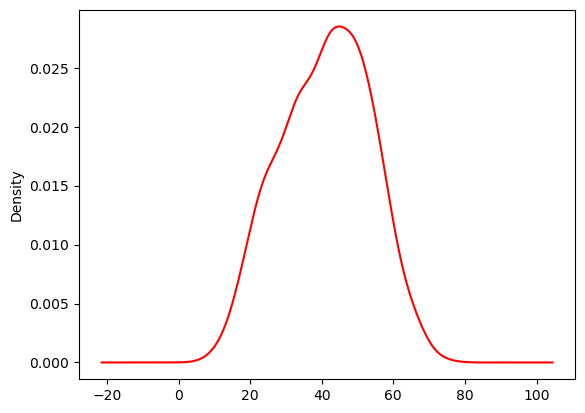

In [21]:
data_scaled['NEXT_W'].plot(kind='kde',c='red')

In [22]:
data_scaled.to_csv('data/nba_data_scaled.csv')

# Training

## Feature/Label Split

In [23]:
def split_data_X_y(data):
    temp = data.copy(deep=False)
    temp.drop(columns=['TEAM_ID','NEXT_SEASON'], inplace=True)
    X = data.iloc[:,2:].copy(deep=False)
    X.drop(columns=['NEXT_W'], inplace=True)
    y = data.iloc[:,-1:].copy(deep=False)
    return X, y

## Train/Val Split

In [24]:
def split_data_train_test(data):
    temp = data.copy(deep=False)
    temp.drop(columns=['TEAM_ID','NEXT_SEASON'], inplace=True)
    X = data.iloc[:,2:].copy(deep=False)
    X.drop(columns=['NEXT_W'], inplace=True)
    y = data.iloc[:,-1:].copy(deep=False)
    X = X.values[:,:,np.newaxis]
    y = y.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)
    return X_train, X_test, y_train, y_test

In [25]:
def rmse(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

In [26]:
# X, y = split_data_X_y(data_scaled)
# X = X.values[:,:,np.newaxis]

In [27]:
X_train, X_test, y_train, y_test = split_data_train_test(data_scaled)

In [28]:
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(312, 19, 1) (135, 19, 1) (312, 1) (135, 1)


# CNN Model

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 模型训练 早停机制
from tensorflow.keras.callbacks import EarlyStopping

# 定义模型架构
model = tf.keras.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(19, 1)))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# monitor:监视参数，min_delta:小于此数认为不变化，mode:loss小好，patience:n周期无提升则退出，restore_best_weights:取最优权重
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min', verbose=1, restore_best_weights = True)

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[earlyStop])

Epoch 1/200
8/8 [==============================] - 2s 45ms/step - loss: 1779.2382 - val_loss: 1690.8923
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 1561.1865 - val_loss: 1312.2954
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 1082.9954 - val_loss: 677.6731
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 485.5071 - val_loss: 373.1594
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 370.6565 - val_loss: 427.0381
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 290.8992 - val_loss: 234.3897
Epoch 7/200
8/8 [==============================] - 0s 13ms/step - loss: 271.2739 - val_loss: 221.0088
Epoch 8/200
8/8 [==============================] - 0s 14ms/step - loss: 245.7629 - val_loss: 187.9688
Epoch 9/200
8/8 [==============================] - 0s 15ms/step - loss: 219.3014 - val_loss: 179.1366
Epoch 10/200
8/8 [==============================] - 0s 15ms/step - loss: 203.10

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 64)                28736     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

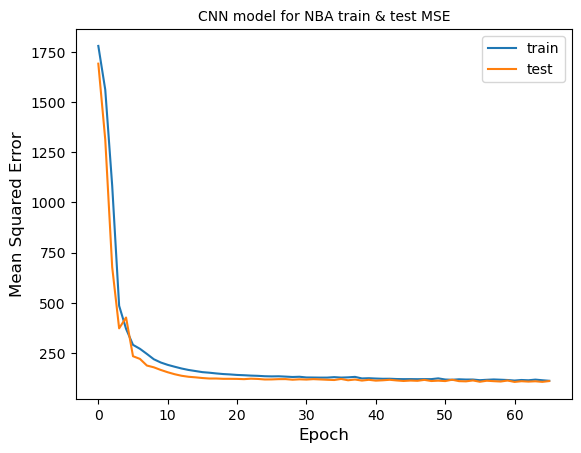

In [31]:
from matplotlib import pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch",fontsize=12)
plt.ylabel("Mean Squared Error",fontsize=12)
plt.legend()
plt.title('CNN model for NBA train & test MSE',fontsize=10)
plt.show();

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def evaluate(y, pred, model = 'model',mode='test'):
    mse = mean_squared_error(y, pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, pred)
    print(f'{model}: \tMSE\t{mode}:{mse:.4f}\n{model}: \tRMSE\t{mode}:{rmse:.4f}\n{model}: \tMAE\t{mode}:{mae:.4f}\n')

In [33]:
# 进行预测
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [34]:
evaluate(y_test,y_pred,'Model test')

Model test: 	MSE	test:119.2114
Model test: 	RMSE	test:10.9184
Model test: 	MAE	test:8.9185



In [71]:
def plot_diff(real,pred,name='name'):
    
    diff = pd.DataFrame(zip(real,pred),columns=['real','pred'])
    ax = diff.plot(marker='$o$',figsize=(15,8),fontsize=12)

    ax.set_xlabel(f"\nTest Sample",fontsize=15)
    ax.set_ylabel(f"\n Value",fontsize=15)
    # ax.set_yticks(np.arange(0,1.1,0.2))
    # ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])  # 自定义轴坐标label
    ax.set_title(f'{name} Model Predict',fontsize=18)
    ax.legend(fontsize=12) #设置图例字体大小
    plt.legend()
    plt.legend(loc=2) #第二象项，也就是左上角。 loc可以为1,2,3,4
    plt.show();

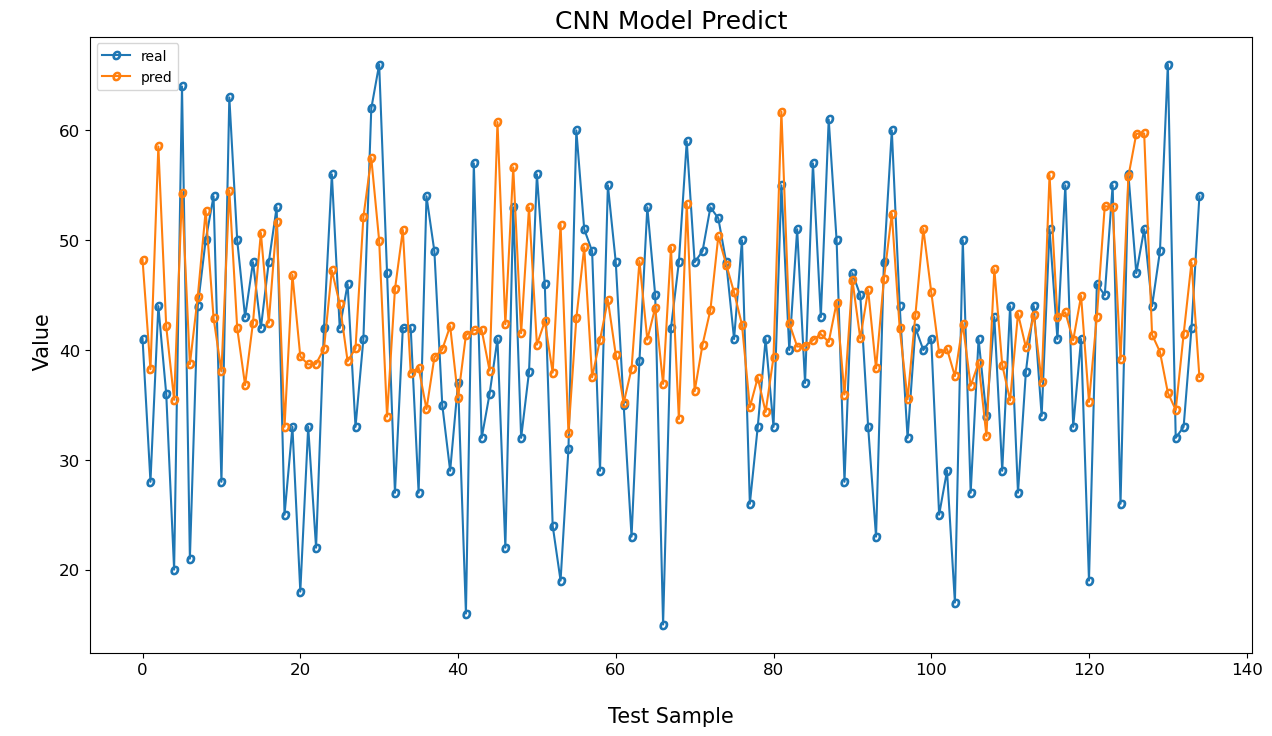

In [72]:
plot_diff(y_test[:,0],y_pred[:,0],name='CNN')

In [37]:
pd.DataFrame(zip(y_test[:,0],y_pred[:,0]),columns=['real','pred'])

,real,pred
0,41,48.187981
1,28,38.246696
2,44,58.535416
3,36,42.141766
4,20,35.465065
...,...,...
130,66,36.120853
131,32,34.537292
132,33,41.422531
133,42,47.985222


# VQR model

In [38]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap,ZFeatureMap
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

C:\Users\tojoy\AppData\Local\Temp\ipykernel_8556\2626464430.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


In [39]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [40]:
from sklearn.decomposition import PCA

X_train = PCA(n_components=2).fit_transform(X_train[:,:,0])
X_test = PCA(n_components=2).fit_transform(X_test[:,:,0])

In [41]:
num_features = X_train.shape[1]
#num_features = 2
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)

In [45]:
# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(num_features, name="vf")
ansatz.ry(param_y, [0,1])

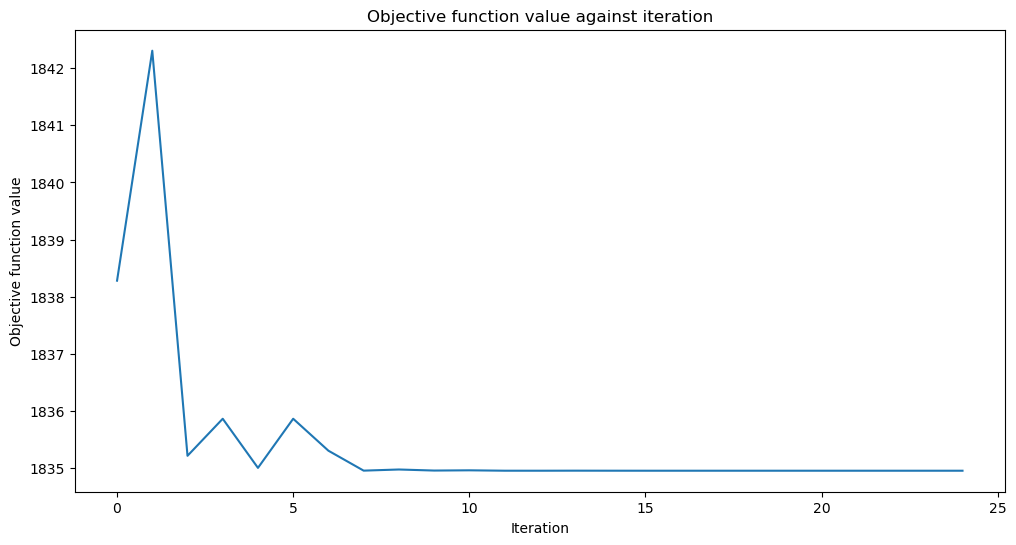

CPU times: total: 1min 8s
Wall time: 1min 38s


In [47]:
%%time
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    loss="squared_error"
)
#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X_train, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [48]:
# R2 score result
vqr.score(X_train, y_train)

-10.430745848487913

In [49]:
vqr_y_pred = vqr.predict(X_test)

In [50]:
evaluate(y_test, vqr_y_pred[:,0],'VQR Model')

VQR Model: 	MSE	test:1833.7297
VQR Model: 	RMSE	test:42.8221
VQR Model: 	MAE	test:41.1494



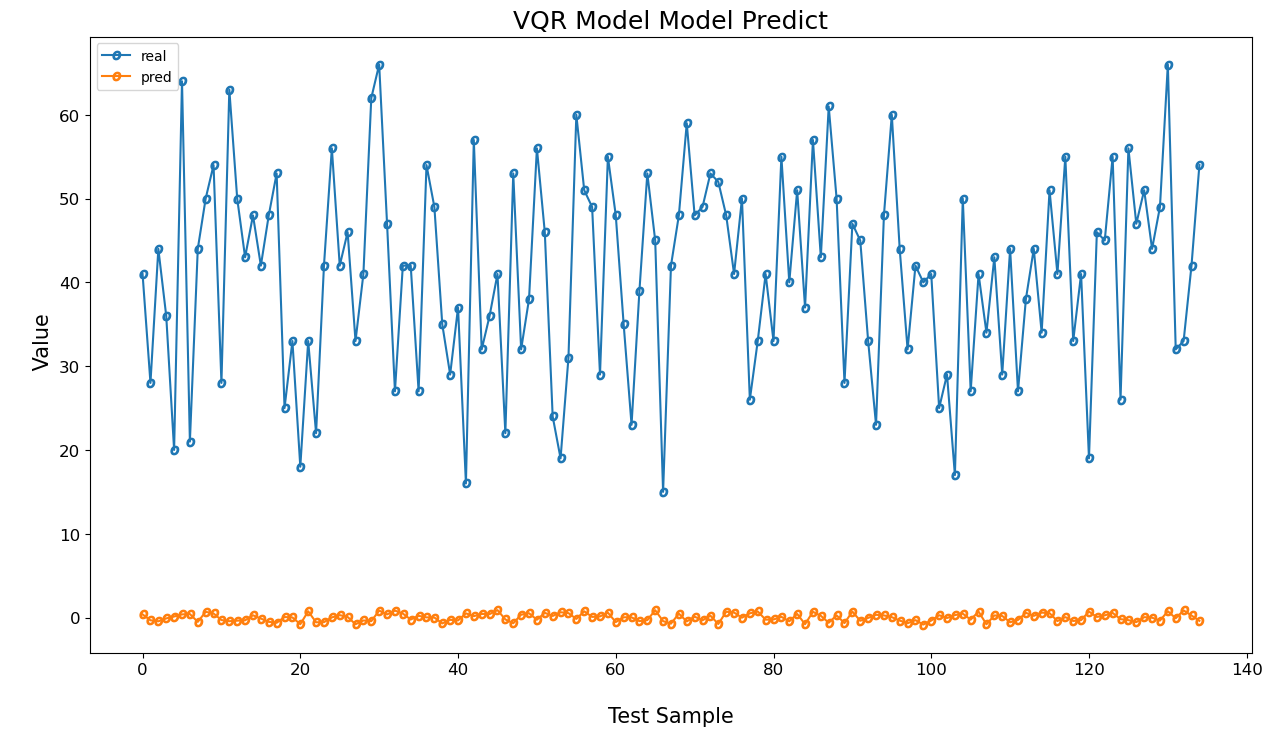

In [73]:
plot_diff(y_test[:,0], vqr_y_pred[:,0],name='VQR Model')

# QNN Model

In [58]:
#f#rom qiskit_ibm_runtime import Sampler, Options, QiskitRuntimeService, Estimator
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [59]:
%%time
# Define the feature map and ansatz
num_qubits = 2
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

# Quantum circuit
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)


#Set up the sampler qnn
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters, 
)

# Set up the neural network classifier
regressor = NeuralNetworkRegressor(
    qnn,
    loss='squared_error',
    optimizer=COBYLA(maxiter=100)
)

# Train the regressor
regressor.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 9.97 ms


In [61]:
# Predict on test data
qnn_y_pred = regressor.predict(X_test)

In [63]:
evaluate(y_test, qnn_y_pred[:,0],'Model test')

Model test: 	MSE	test:1836.4243
Model test: 	RMSE	test:42.8535
Model test: 	MAE	test:41.1799



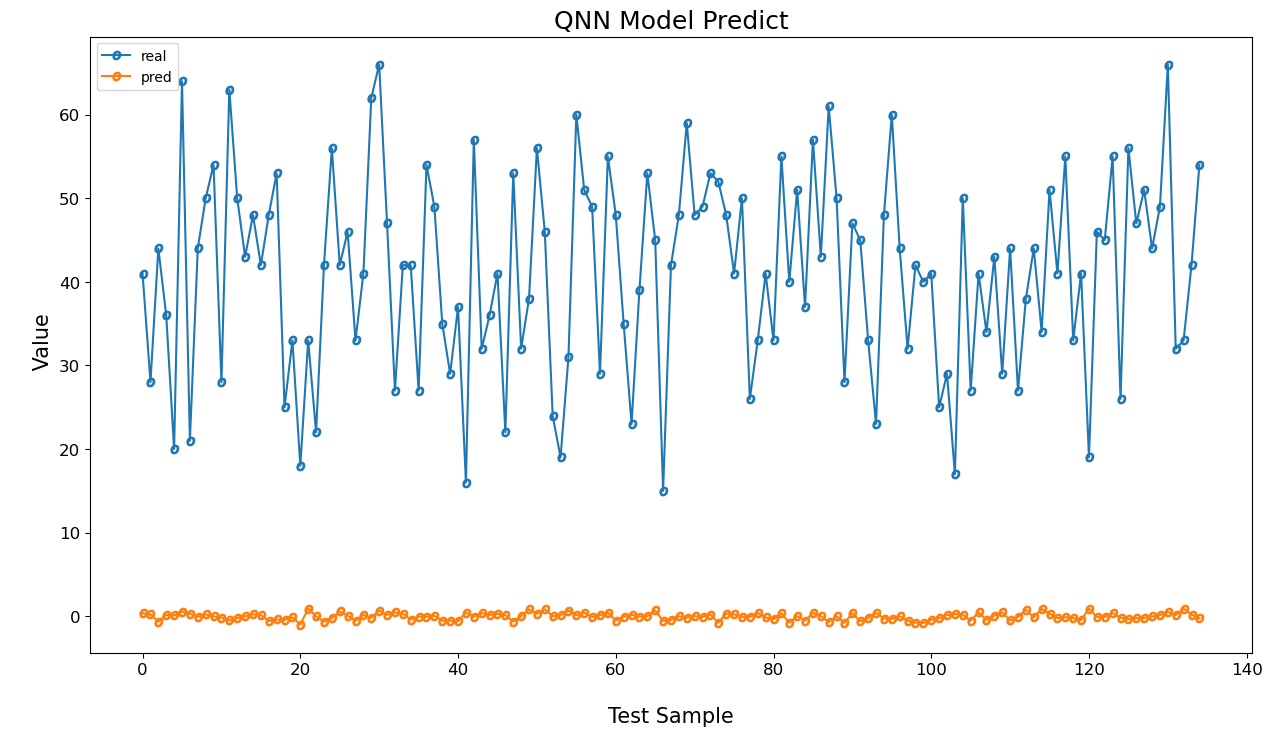

In [74]:
plot_diff(y_test[:,0], qnn_y_pred[:,0],name='QNN')

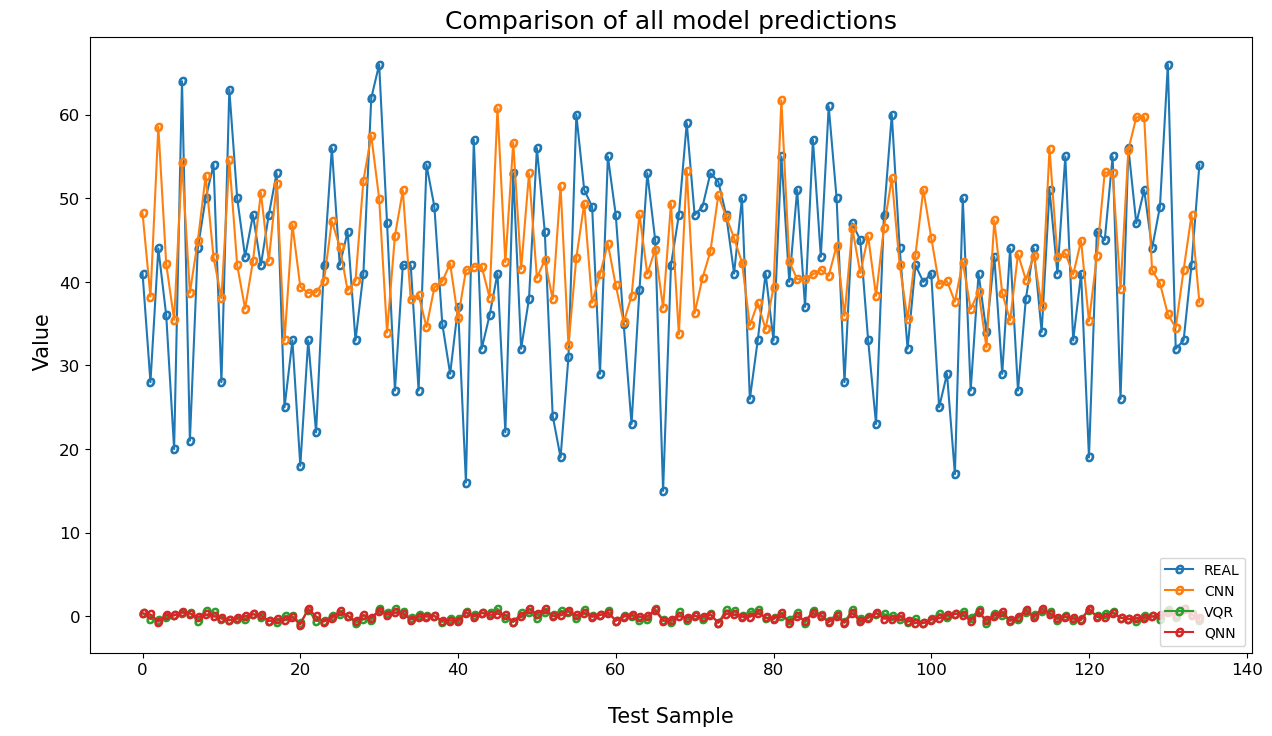

In [70]:
diff = pd.DataFrame(zip(y_test[:,0],y_pred[:,0],vqr_y_pred[:,0],qnn_y_pred[:,0]),columns=['REAL','CNN','VQR','QNN'])
ax = diff.plot(marker='$o$',figsize=(15,8),fontsize=12)
ax.set_xlabel(f"\nTest Sample",fontsize=15)
ax.set_ylabel(f"\n Value",fontsize=15)
# ax.set_yticks(np.arange(0,1.1,0.2))
# ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])  # 自定义轴坐标label
ax.set_title(f'Comparison of all model predictions',fontsize=18)
ax.legend(fontsize=12) #设置图例字体大小
plt.legend()
plt.legend(loc=4) #第二象项，也就是左上角。 loc可以为1,2,3,4
plt.show();